# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [3]:
#env = gym.make('CartPole-v0')
env = gym.make('Acrobot-v1')
env.seed(0)
print('observation space:', env.observation_space)
print('Atlantis-ram-v0:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    #def __init__(self, s_size=4, h_size=16, a_size=2):
    def __init__(self, s_size=6, a_size=3):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, 16)
        #self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(16, 32)
        #self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(32, 16)
        #self.bn3 = nn.BatchNorm1d(256)
        
        self.fc4 = nn.Linear(16, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        x = self.fc4(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(6,)
Atlantis-ram-v0: Discrete(3)


In [4]:
def Print():
    #env = gym.make('CartPole-v0')
    env = gym.make('Acrobot-v1')

    state = env.reset()
    for t in range(1000):
        action, _ = policy.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        #if done:
        #    break 

    env.close()
    

### 3. Train the Agent with REINFORCE

In [8]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
        if i_episode % print_every == 0:
            torch.save(policy.state_dict(), 'iter%d.pth' % i_episode)
            Print()
    return scores
    
scores = reinforce()

Episode 100	Average Score: -336.20
Episode 200	Average Score: -195.28
Episode 300	Average Score: -154.33
Episode 400	Average Score: -131.76
Episode 500	Average Score: -136.17
Episode 600	Average Score: -120.69
Episode 700	Average Score: -129.20
Episode 800	Average Score: -113.41
Episode 900	Average Score: -116.49
Episode 1000	Average Score: -107.82


In [16]:
def Display():
    env = gym.make('Acrobot-v1')

    state = env.reset()
    for i in range(10):
        iter = (i+1)*100
        policy.load_state_dict(torch.load('iter%d.pth'% iter))
        for t in range(1000):
            action, _ = policy.act(state)
            env.render()
            state, reward, done, _ = env.step(action)
        #if done:
        #    break 

    env.close()
    

In [21]:
Display()

KeyboardInterrupt: 

### 4. Plot the Scores

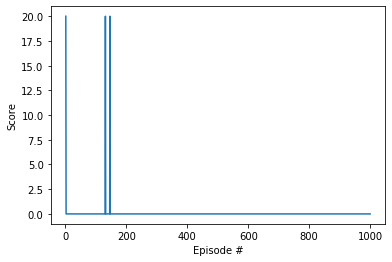

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [21]:
#env = gym.make('CartPole-v0')
env = gym.make('Acrobot-v1')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    #if done:
    #    break 

env.close()